In [24]:
import pandas as pd 

In [25]:
data = pd.read_csv('insurance_dataset.csv')

In [26]:
X = data.drop(['gender','region','exercise_frequency','occupation', 'charges'], axis=1)[:1000]
y = data['charges'][:1000]

In [27]:
X['medical_history'] = X['medical_history'].fillna('Unknown')
X['family_medical_history'] = X['family_medical_history'].fillna('Unknown')

In [28]:
print(X.shape)
print(y.shape)

(1000, 7)
(1000,)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=44)

In [30]:
X.columns

Index(['age', 'bmi', 'children', 'smoker', 'medical_history',
       'family_medical_history', 'coverage_level'],
      dtype='object')

In [31]:
X.isna().sum()

age                       0
bmi                       0
children                  0
smoker                    0
medical_history           0
family_medical_history    0
coverage_level            0
dtype: int64

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.compose import TransformedTargetRegressor


# Individual transformers
age_transformer = Pipeline([
    ('scaler', StandardScaler())
])

bmi_transformer = Pipeline([
    ('scaler', StandardScaler())
])

children_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])

smoker_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])

medical_history_transformer = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=True))
])

family_medical_history_transformer = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=True))
])

coverage_level_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])

charges_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('age_transformer', age_transformer, ['age']),
        ('bmi_transformer', bmi_transformer, ['bmi']),
        ('children_transformer', children_transformer, ['children']),
        ('smoker_transformer', smoker_transformer, ['smoker']),
        ('medical_history_transformer', medical_history_transformer, ['medical_history']),
        ('family_medical_history_transformer', family_medical_history_transformer, ['family_medical_history']),
        ('coverage_level_transformer', coverage_level_transformer, ['coverage_level'])
    ],
    remainder='passthrough'
)

regressors = {
    'linear_regression': LinearRegression(),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=44),
    'gradient_boosting': GradientBoostingRegressor(n_estimators=100, random_state=44),
    'svr': SVR(kernel='rbf'),
    'decision_tree': DecisionTreeRegressor(random_state=44)
}

# pipelines = {
#     name: Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('regressor', reg)
#     ]) for name, reg in regressors.items()
# }

pipelines = {
    name: Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', TransformedTargetRegressor(
            regressor=reg,
            transformer=StandardScaler()  
        ))
    ]) for name, reg in regressors.items()
}

In [33]:
param_grid = {
    'linear_regression': {}, 
    'random_forest': {
        'regressor__regressor__n_estimators': [100, 200],
        'regressor__regressor__max_depth': [10, 20],
        'regressor__regressor__min_samples_split': [2, 5]
    },
    'gradient_boosting': {
        'regressor__regressor__n_estimators': [100, 200],
        'regressor__regressor__learning_rate': [0.01, 0.1],
        'regressor__regressor__max_depth': [3, 5]
    },
    'svr': {
        'regressor__regressor__C': [0.1, 1],
        'regressor__regressor__kernel': ['rbf', 'linear']
    },
    'decision_tree': {
        'regressor__regressor__max_depth': [5, 10],
        'regressor__regressor__min_samples_split': [2, 5]
    }
}


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# First, select one pipeline to use with GridSearchCV
# Let's create a dictionary to store all results
best_models = {}

for model_name, pipeline in pipelines.items():
    # Create param grid for current model
    current_param_grid = param_grid[model_name]
    
    # Create GridSearchCV for current model
    grid_search = GridSearchCV(
        estimator=pipeline,  # Pass single pipeline instead of dictionary
        param_grid=current_param_grid,
        cv=5,
        n_jobs=-1,
        verbose=True,
        scoring='neg_mean_squared_error'  # Note: 'mse' is deprecated, use 'neg_mean_squared_error'
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store results
    best_models[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to MSE from negative MSE
        'best_estimator': grid_search.best_estimator_
    }


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [48]:
# Find the best overall model
best_model_name = min(best_models, key=lambda x: best_models[x]['best_score'])
best_overall_model = best_models[best_model_name]['best_estimator']

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


# 1. Print best model results
print("\n=== Best Model Results ===")
print(f"Best Model: {best_model_name}")
print(f"Best Score (MSE): {best_models[best_model_name]['best_score']:.4f}")
print(f"Best Parameters: {best_models[best_model_name]['best_params']}")


=== Best Model Results ===
Best Model: gradient_boosting
Best Score (MSE): 1928169.7926
Best Parameters: {'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__max_depth': 3, 'regressor__regressor__n_estimators': 100}


In [38]:
import pickle
# Save the best model using pickle
model_file_path = f"{best_model_name}_best_model.pkl"
with open(model_file_path, 'wb') as file:
    pickle.dump(best_overall_model, file)

print(f"\nBest model saved as: {model_file_path}")


Best model saved as: gradient_boosting_best_model.pkl


In [39]:
# 2. Get predictions for all models
predictions = {}
scores = {}

for model_name, model_info in best_models.items():
    model = model_info['best_estimator']
    predictions[model_name] = model.predict(X_test)
    scores[model_name] = {
        'mse': mean_squared_error(y_test, predictions[model_name]),
        'r2': r2_score(y_test, predictions[model_name])
    }

In [40]:
# 3. Create feature importance plot (for tree-based models)
def plot_feature_importance(model_name, model):
    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
        # Get feature names after preprocessing
        preprocessor = model.named_steps['preprocessor']
        feature_names = (
            preprocessor.get_feature_names_out()
        )
        
        # Get feature importances
        importances = model.named_steps['regressor'].feature_importances_
        
        # Create DataFrame for plotting
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance_df, x='importance', y='feature')
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()

# Plot feature importance for tree-based models
for model_name, model_info in best_models.items():
    if model_name in ['random_forest', 'gradient_boosting', 'decision_tree']:
        plot_feature_importance(model_name, model_info['best_estimator'])

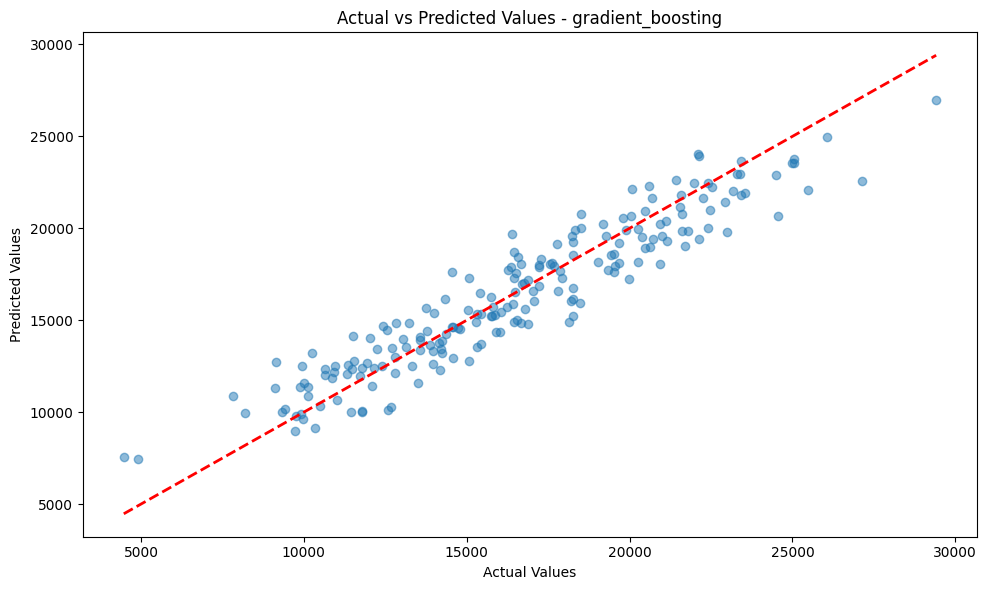

In [41]:
# 4. Plot actual vs predicted values for best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions[best_model_name], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values - {best_model_name}')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

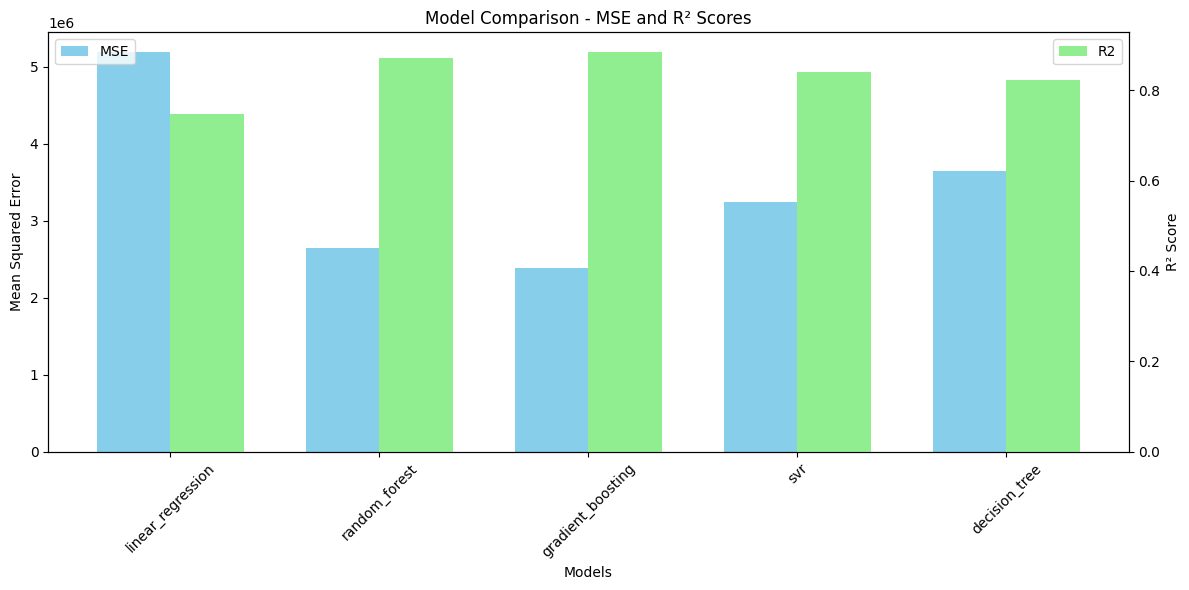

In [42]:
# 5. Plot model comparison
plt.figure(figsize=(10, 6))
mse_scores = [scores[model]['mse'] for model in scores]
r2_scores = [scores[model]['r2'] for model in scores]

x = np.arange(len(scores))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, mse_scores, width, label='MSE', color='skyblue')
bars2 = ax2.bar(x + width/2, r2_scores, width, label='R2', color='lightgreen')

ax1.set_xlabel('Models')
ax1.set_ylabel('Mean Squared Error')
ax2.set_ylabel('R² Score')

ax1.set_xticks(x)
ax1.set_xticklabels(scores.keys(), rotation=45)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Model Comparison - MSE and R² Scores')
plt.tight_layout()
plt.show()


In [43]:
# 6. Print detailed evaluation metrics
print("\n=== Model Evaluation Metrics ===")
for model_name, model_scores in scores.items():
    print(f"\n{model_name}:")
    print(f"MSE: {model_scores['mse']:.4f}")
    print(f"R²: {model_scores['r2']:.4f}")
    print(f"RMSE: {np.sqrt(model_scores['mse']):.4f}")


=== Model Evaluation Metrics ===

linear_regression:
MSE: 5184887.7961
R²: 0.7462
RMSE: 2277.0349

random_forest:
MSE: 2645781.9490
R²: 0.8705
RMSE: 1626.5860

gradient_boosting:
MSE: 2380246.4361
R²: 0.8835
RMSE: 1542.8047

svr:
MSE: 3247734.1746
R²: 0.8411
RMSE: 1802.1471

decision_tree:
MSE: 3640810.9831
R²: 0.8218
RMSE: 1908.0909


In [44]:
# 7. Make predictions with the best model
final_predictions = best_models[best_model_name]['best_estimator'].predict(X_test)

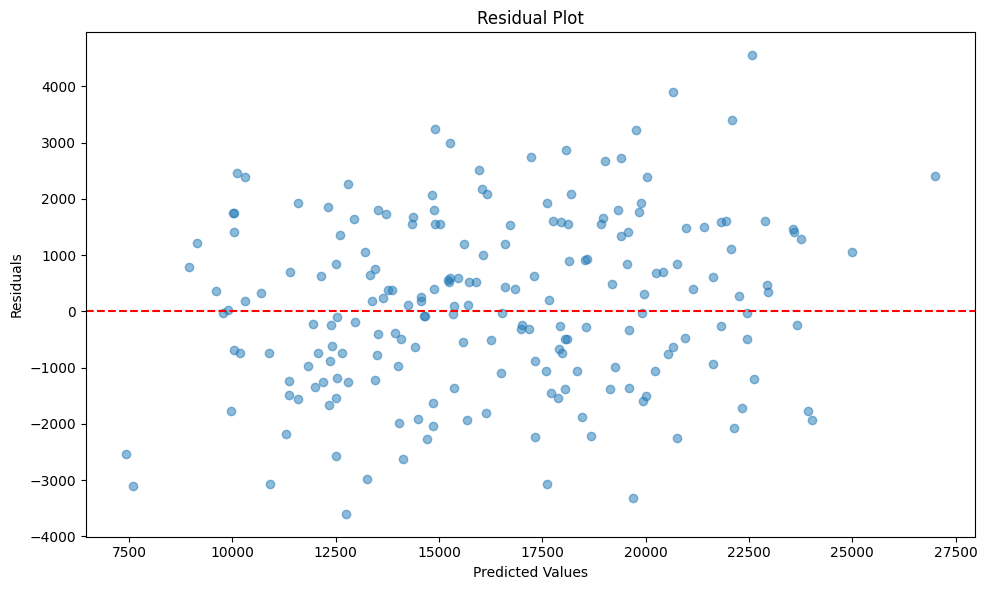

In [45]:
# 8. Create residual plot
residuals = y_test - final_predictions
plt.figure(figsize=(10, 6))
plt.scatter(final_predictions, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [46]:
# 9. Save predictions to DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': final_predictions,
    'Residual': residuals
})
# Optional: Save results to CSV
# results_df.to_csv('prediction_results.csv', index=False)

print("\n=== Sample of Predictions ===")
print(results_df.head())


=== Sample of Predictions ===
           Actual     Predicted     Residual
118  21110.229332  20415.193066   695.036265
19   13775.765035  14413.170282  -637.405247
41   15075.217324  17316.501689 -2241.284365
425  25489.262328  22084.639495  3404.622833
221  21134.978580  19331.547636  1803.430944


In [47]:
# 10. Print error distribution statistics
print("\n=== Error Distribution Statistics ===")
print(results_df['Residual'].describe())


=== Error Distribution Statistics ===
count     200.000000
mean      131.107051
std      1541.081451
min     -3598.657477
25%      -972.235015
50%       182.936090
75%      1409.965838
max      4553.401411
Name: Residual, dtype: float64
